In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
import matplotlib.patches as mpatches

## Loading the dataset

In [2]:
Xtrain_main = rasterio.open('Xtrain.tif').read()
Ytrain_main = rasterio.open('Ytrain.tif').read()
Xtest_main = rasterio.open('Xtest.tif').read()
Ytest_main = rasterio.open('Ytest_v2.tif').read()

In [3]:
print("shape of Xtrain: ", Xtrain_main.shape)
print("shape of Ytrain: ", Ytrain_main.shape)
print("shape of Xtest: ", Xtest_main.shape)
print("shape of Ytest: ", Ytest_main.shape)  #need to remake the dataset

shape of Xtrain:  (4, 1953, 2161)
shape of Ytrain:  (1, 1953, 2161)
shape of Xtest:  (4, 461, 490)
shape of Ytest:  (1, 461, 490)


/tmp/ipykernel_142/71467182.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)


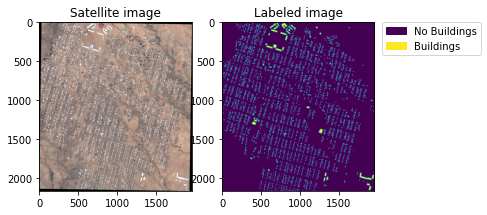

In [4]:
#Visualize the data

def visualize_data(data,data2):
    f, axarr = plt.subplots(1,2)
    data = data[:, :, 0:3]
    _ = data[:, :, 0].copy()
    data[:, :, 0] = data[:, :, 2]
    data[:, :, 2] = _
    data = data.astype(np.float)
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i],
                                                      in_range=(p2, p98))
    axarr[0].imshow(data)
    axarr[0].set_title("Satellite image")

    a=axarr[1]
    values = np.unique(data2.ravel())
    im = axarr[1].imshow(data2[:,:,0])
    a.set_title("Labeled image")
    colors = [im.cmap(im.norm(value)) for value in values] 
    data2 = ["No Buildings", "Buildings"]
    patches = [mpatches.Patch(color=colors[i], label=j) for i, j in zip(range(len(values)), data2)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

visualize_data(Xtrain_main.swapaxes(0,2),Ytrain_main.swapaxes(0,2)) #Visualize Images Side by Side

## Image Patching

Instead of random patching, here we are creating patches from entire dataset as we lack enough dataset.

In [5]:
PATCHSIZE = 128
NBANDS = Xtrain_main.shape[0]

def gridwise_sample(imgarray, patchsize):
    ''' to make a grid of 256x256 on top of the image and create sample patches '''
    nbands,nrows, ncols = imgarray.shape
    patchsamples = np.zeros(shape=(0, nbands,patchsize, patchsize),
                            dtype=imgarray.dtype)
    
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[:,i*patchsize:(i+1)*patchsize,
                             j*patchsize:(j+1)*patchsize]
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples

In [6]:
Xtrain = gridwise_sample(Xtrain_main, PATCHSIZE)
Ytrain = gridwise_sample(Ytrain_main, PATCHSIZE)
print("There are %i number of training patches" % (Xtrain.shape[0]))

There are 240 number of training patches


## Augmentation
Since there are fewer number of samples lets do the augmentation on Flip and Mirror

In [7]:
Xtrain_fliped = Xtrain[:,:,::-1, :]
Xtrain_mirrored = Xtrain[:,:,:,::-1]
Ytrain_fliped = Ytrain[:,:,::-1, :]
Ytrain_mirrored = Ytrain[:,:,:,::-1]

In [8]:
Xtrain.shape,Ytrain.shape

((240, 4, 128, 128), (240, 1, 128, 128))

/tmp/ipykernel_142/71467182.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)


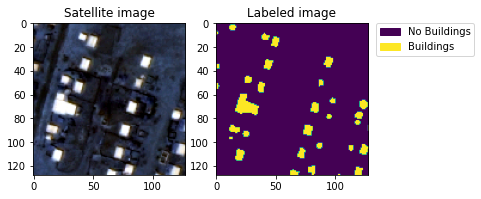

In [9]:
visualize_data(Xtrain[40].swapaxes(0,2),Ytrain[40].swapaxes(0,2))

/tmp/ipykernel_142/71467182.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)


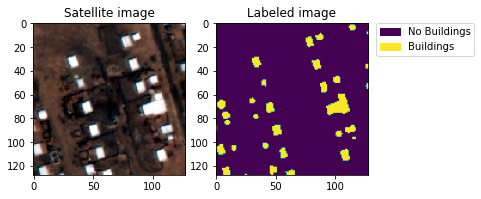

In [10]:
visualize_data(Xtrain_fliped[40].swapaxes(0,2),Ytrain_fliped[40].swapaxes(0,2))

/tmp/ipykernel_142/71467182.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)


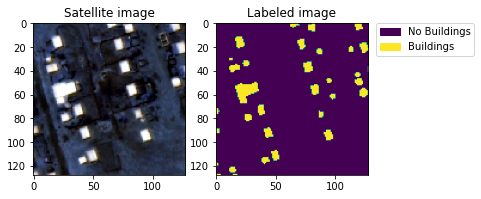

In [11]:
visualize_data(Xtrain_mirrored[40].swapaxes(0,2),Ytrain_mirrored[40].swapaxes(0,2))

In [12]:
#Lets append the datasets
Xtrain_fliped=np.append(Xtrain,Xtrain_fliped,axis=0)
Xtrain=np.append(Xtrain_fliped,Xtrain_mirrored,axis=0)
Ytrain_fliped=np.append(Ytrain,Ytrain_fliped,axis=0)
Ytrain=np.append(Ytrain_fliped,Ytrain_mirrored,axis=0)

In [13]:
Ytrain.shape

(720, 1, 128, 128)

## One hot Encoding
The Ytrain dataset only have 1 band which includes 0 for no buildings and 1 for buildings, so lets make it one hot encoding. In this case we will have to change 0 to [1,0] and 1 to [0,1]

In [14]:
ones=np.ones(Ytrain.shape)
ytrain_inverted=ones-Ytrain # Because 1-0 is 1 and 1-0 is zero
Ytrain=np.concatenate((ytrain_inverted,Ytrain),axis=1)
Ytrain.shape

(720, 2, 128, 128)

## convert to pytorch dataset
Lets convert the numpy array to pytorch datset

In [16]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

tensor_x = torch.Tensor(Xtrain) 
tensor_y = torch.Tensor(Ytrain)

tensor_dataset = TensorDataset(tensor_x,tensor_y) 
train_data = DataLoader(tensor_dataset) 

In [17]:
WINDOW_SIZE = (128, 128) # Patch size
STRIDE = 32 # Stride for testing
IN_CHANNELS = 4 # Number of input channels (e.g. RGB)
##FOLDER = "./ISPRS_dataset/" # Replace with your "/path/to/the/ISPRS/dataset/folder/"
BATCH_SIZE = 5 # Number of samples in a mini-batch

LABELS = ["no buildings", "buildings"] # Label names
N_CLASSES = len(LABELS) # Number of classes
WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
CACHE = True # Store the dataset in-memory

In [18]:
# Utils

def get_random_pos(img, window_shape):
    """ Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2

def CrossEntropy2d(input, target, weight=None, size_average=True):
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
##        return nn.CrossEntropyLoss(output, target,weight)
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        return F.cross_entropy(output, target,weight, size_average)
##        return nn.CrossEntropyLoss(output, target,weight)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size

def sliding_window(top, step=10, window_size=(20,20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

def metrics(predictions, gts, label_values=LABELS):
    cm = confusion_matrix(
            gts,
            predictions,
            labels=range(len(label_values)))
    
    print("Confusion matrix :")
    print(cm)
    
    print("---")
    
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))
    
    print("---")
    
    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("F1Score :")
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(label_values[l_id], score))

    print("---")
        
    # Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))
    return accuracy

## Define the network
Lets define the SegNet model from previous notebook.

In [19]:
""" Defining Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [20]:

class SegNet(nn.Module):
    # SegNet network
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal(m.weight.data)
    
    def __init__(self, in_channels=IN_CHANNELS, out_channels=N_CLASSES):
        super(SegNet, self).__init__()
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        
        self.conv1_1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(64)
        
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(128)
        
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(256)
        
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_bn = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_bn = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_D_bn = nn.BatchNorm2d(512)
        self.conv5_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_D_bn = nn.BatchNorm2d(512)
        self.conv5_1_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_D_bn = nn.BatchNorm2d(512)
        
        self.conv4_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_D_bn = nn.BatchNorm2d(512)
        self.conv4_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_D_bn = nn.BatchNorm2d(512)
        self.conv4_1_D = nn.Conv2d(512, 256, 3, padding=1)
        self.conv4_1_D_bn = nn.BatchNorm2d(256)
        
        self.conv3_3_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_D_bn = nn.BatchNorm2d(256)
        self.conv3_2_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_D_bn = nn.BatchNorm2d(256)
        self.conv3_1_D = nn.Conv2d(256, 128, 3, padding=1)
        self.conv3_1_D_bn = nn.BatchNorm2d(128)
        
        self.conv2_2_D = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_D_bn = nn.BatchNorm2d(128)
        self.conv2_1_D = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2_1_D_bn = nn.BatchNorm2d(64)
        
        self.conv1_2_D = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_D_bn = nn.BatchNorm2d(64)
        self.conv1_1_D = nn.Conv2d(64, out_channels, 3, padding=1)
        
        self.apply(self.weight_init)
        
    def forward(self, x):
        # Encoder block 1
        x = self.conv1_1_bn(F.relu(self.conv1_1(x)))
        x = self.conv1_2_bn(F.relu(self.conv1_2(x)))
        x, mask1 = self.pool(x)
        
        # Encoder block 2
        x = self.conv2_1_bn(F.relu(self.conv2_1(x)))
        x = self.conv2_2_bn(F.relu(self.conv2_2(x)))
        x, mask2 = self.pool(x)
        
        # Encoder block 3
        x = self.conv3_1_bn(F.relu(self.conv3_1(x)))
        x = self.conv3_2_bn(F.relu(self.conv3_2(x)))
        x = self.conv3_3_bn(F.relu(self.conv3_3(x)))
        x, mask3 = self.pool(x)
        
        # Encoder block 4
        x = self.conv4_1_bn(F.relu(self.conv4_1(x)))
        x = self.conv4_2_bn(F.relu(self.conv4_2(x)))
        x = self.conv4_3_bn(F.relu(self.conv4_3(x)))
        x, mask4 = self.pool(x)
        
        # Encoder block 5
        x = self.conv5_1_bn(F.relu(self.conv5_1(x)))
        x = self.conv5_2_bn(F.relu(self.conv5_2(x)))
        x = self.conv5_3_bn(F.relu(self.conv5_3(x)))
        x, mask5 = self.pool(x)
        
        # Decoder block 5
        x = self.unpool(x, mask5)
        x = self.conv5_3_D_bn(F.relu(self.conv5_3_D(x)))
        x = self.conv5_2_D_bn(F.relu(self.conv5_2_D(x)))
        x = self.conv5_1_D_bn(F.relu(self.conv5_1_D(x)))
        
        # Decoder block 4
        x = self.unpool(x, mask4)
        x = self.conv4_3_D_bn(F.relu(self.conv4_3_D(x)))
        x = self.conv4_2_D_bn(F.relu(self.conv4_2_D(x)))
        x = self.conv4_1_D_bn(F.relu(self.conv4_1_D(x)))
        
        # Decoder block 3
        x = self.unpool(x, mask3)
        x = self.conv3_3_D_bn(F.relu(self.conv3_3_D(x)))
        x = self.conv3_2_D_bn(F.relu(self.conv3_2_D(x)))
        x = self.conv3_1_D_bn(F.relu(self.conv3_1_D(x)))
        
        # Decoder block 2
        x = self.unpool(x, mask2)
        x = self.conv2_2_D_bn(F.relu(self.conv2_2_D(x)))
        x = self.conv2_1_D_bn(F.relu(self.conv2_1_D(x)))
        
        # Decoder block 1
        x = self.unpool(x, mask1)
        x = self.conv1_2_D_bn(F.relu(self.conv1_2_D(x)))
        x = F.log_softmax(self.conv1_1_D(x))
        return x


In [21]:
# instantiate the network
net = SegNet()

We download and load the pre-trained weights from VGG-16 on ImageNet. This step is optional but it makes the network converge faster. We skip the weights from VGG-16 that have no counterpart in SegNet.


In [22]:
import os
try:
    from urllib.request import URLopener
except ImportError:
    from urllib import URLopener

# Download VGG-16 weights from PyTorch
vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
if not os.path.isfile('./vgg16_bn-6c64b313.pth'):
    weights = URLopener().retrieve(vgg_url, './vgg16_bn-6c64b313.pth')

vgg16_weights = torch.load('./vgg16_bn-6c64b313.pth')
mapped_weights = {}
for k_vgg, k_segnet in zip(vgg16_weights.keys(), net.state_dict().keys()):
    if "features" in k_vgg:
        mapped_weights[k_segnet] = vgg16_weights[k_vgg]
        print("Mapping {} to {}".format(k_vgg, k_segnet))
        
try:
    net.load_state_dict(mapped_weights)
    print("Loaded VGG-16 weights in SegNet !")
except:
    # Ignore missing keys
    pass

Mapping features.0.weight to conv1_1.weight
Mapping features.0.bias to conv1_1.bias
Mapping features.1.weight to conv1_1_bn.weight
Mapping features.1.bias to conv1_1_bn.bias
Mapping features.1.running_mean to conv1_1_bn.running_mean
Mapping features.1.running_var to conv1_1_bn.running_var
Mapping features.3.weight to conv1_1_bn.num_batches_tracked
Mapping features.3.bias to conv1_2.weight
Mapping features.4.weight to conv1_2.bias
Mapping features.4.bias to conv1_2_bn.weight
Mapping features.4.running_mean to conv1_2_bn.bias
Mapping features.4.running_var to conv1_2_bn.running_mean
Mapping features.7.weight to conv1_2_bn.running_var
Mapping features.7.bias to conv1_2_bn.num_batches_tracked
Mapping features.8.weight to conv2_1.weight
Mapping features.8.bias to conv2_1.bias
Mapping features.8.running_mean to conv2_1_bn.weight
Mapping features.8.running_var to conv2_1_bn.bias
Mapping features.10.weight to conv2_1_bn.running_mean
Mapping features.10.bias to conv2_1_bn.running_var
Mapping fe

In [23]:
net.cuda()

SegNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv1_1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1_bn): BatchNorm2d(256, eps=1e-05, mom


# Designing the optimizer

We use the standard Stochastic Gradient Descent algorithm to optimize the network's weights.

The encoder is trained at half the learning rate of the decoder, as we rely on the pre-trained VGG-16 weights. We use the `torch.optim.lr_scheduler` to reduce the learning rate by 10 after 25, 35 and 45 epochs.


In [24]:
base_lr = 0.01
params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr / 2}]

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)
# We define the scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [25, 35, 45], gamma=0.1)

# Training the network

Let's train the network for 1 epoch to see how it works (back at work, better train for 50 epochs). The `matplotlib` graph is periodically udpated with the loss plot and a sample inference. It might takes a few minutes on GPUs in the cloud.

If using the notebook on your own machine with the full 50 epochs, depending on your GPU, this might take from a few hours (Titan Pascal) to a full day (old K20).


In [28]:
from IPython.display import clear_output
def train(net, optimizer, epochs, scheduler=None, save_epoch = 5):
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    running_loss = 0.
    last_loss = 0.
    loss_fn=torch.nn.CrossEntropyLoss()
    iter_ = 0
    
    for e in range(1, epochs + 1):
        if scheduler is not None:
            scheduler.step()
        net.train()
        
        
        for batch_idx, (data,target) in enumerate(train_data):
            data,target = Variable(data.cuda()), Variable(target.cuda())
            optimizer.zero_grad()
            #print(inputs.cpu().numpy().shape)
            output = net(data)
            
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
        
            losses[iter_] = loss.item() ##loss.data[0]
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])
            
            if iter_ % 100 == 0:
                clear_output()
                rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
                pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                gt = np.argmax(target.data.cpu().numpy()[0],axis=0)
                print(pred.shape,gt.shape)
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                    e, epochs, batch_idx, len(train_data),
                    100. * batch_idx / len(train_data), loss.item(), accuracy(pred, gt))) ##loss.data[0]
                plt.plot(mean_losses[:iter_]) and plt.show()
                fig = plt.figure()
                fig.add_subplot(131)
                plt.imshow(rgb)
                plt.title('RGB')
                fig.add_subplot(132)
                plt.imshow(gt)
                plt.title('Ground truth')
                fig.add_subplot(133)
                plt.title('Prediction')
                plt.imshow(pred)
                plt.show()
            iter_ += 1

            del(data, target, loss)
    torch.save(net.state_dict(), './segnet_v1')


(128, 128) (128, 128)
Train (epoch 10/10) [620/720 (86%)]	Loss: 0.076343	Accuracy: 97.18017578125


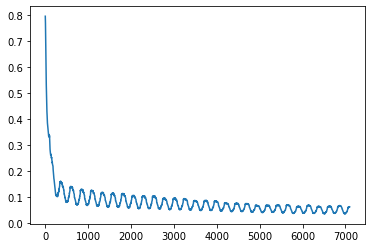

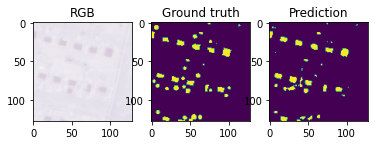

/tmp/ipykernel_807/2835672629.py:131: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.conv1_1_D(x))


In [29]:
train(net, optimizer, 10, scheduler)

## Testing building segmentation on SegNet

/tmp/ipykernel_807/71467182.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)


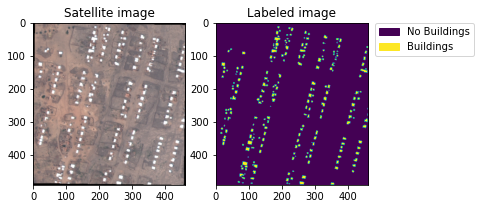

In [30]:
#Visualize the data
visualize_data(Xtest_main.swapaxes(0,2),Ytest_main.swapaxes(0,2)) #Visualize Images Side by Side

In [31]:
#creating test dataset patches
Xtest = gridwise_sample(Xtest_main, PATCHSIZE)
Ytest = gridwise_sample(Ytest_main, PATCHSIZE)
print("There are %i number of training patches" % (Xtest.shape[0]))

There are 9 number of training patches


In [32]:
#one hot encoding on test dataset
ones=np.ones(Ytest.shape)
ytest_inverted=ones-Ytest # Because 1-0 is 1 and 1-0 is zero
Ytest=np.concatenate((ytest_inverted,Ytest),axis=1)
Ytest.shape

(9, 2, 128, 128)

In [33]:
#converting to tensor
tensor_x = torch.Tensor(Xtest) 
tensor_y = torch.Tensor(Ytest)

tensor_dataset = TensorDataset(tensor_x,tensor_y) 
test_data = DataLoader(tensor_dataset) 

In [34]:
# Utils
LABELS=['No Buildings','Buildings']

from sklearn.metrics import confusion_matrix

def metrics(predictions, gts, label_values=LABELS):
    cm = confusion_matrix(
            gts,
            predictions,
            labels=range(len(label_values)))
    
    print("Confusion matrix :")
    print(cm)
    
    print("---")
    
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))
    
    print("---")
    
    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("F1Score :")
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(label_values[l_id], score))

    print("---")
        
    # Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))
    return accuracy

In [35]:
def test():
    all_preds = []
    all_gts = []
    all_acs=[]
    net.eval()
    for test_idx, (data,target) in enumerate(test_data):
        print(f'--------------Testing on patch number: {test_idx+1}----------------- ')
        data,target = Variable(data.cuda()), Variable(target.cuda())
        output = net(data)

        pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
        gt = np.argmax(target.data.cpu().numpy()[0],axis=0)

        # Display the result
        rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
        fig = plt.figure()
        fig.add_subplot(131)
        plt.imshow(rgb)
        plt.title('RGB')
        fig.add_subplot(132)
        plt.imshow(gt)
        plt.title('Ground truth')
        fig.add_subplot(133)
        plt.title('Prediction')
        plt.imshow(pred)
        plt.show()
        all_preds.append(pred)
        all_gts.append(gt)
        #return pred.ravel(),gt_e.ravel()
        # Compute some metrics
        metrics(pred.ravel(), gt.ravel())
        accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel())
        all_acs.append(accuracy)
    print(f'--------------Overall Accuracy: ----------------- ')
    print(f'Mean accuracy in test set is: {sum(all_acs) / len(all_acs)}')
    return all_acs

--------------Testing on patch number: 1----------------- 


/tmp/ipykernel_807/2835672629.py:131: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.conv1_1_D(x))


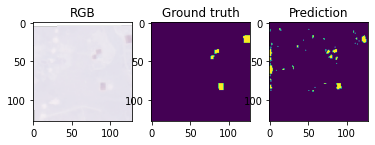

Confusion matrix :
[[15968   222]
 [   69   125]]
---
16384 pixels processed
Total accuracy : 98.223876953125%
---
F1Score :
No Buildings: 0.9909703044031403
Buildings: 0.46210720887245843
---
Kappa: 0.4538108590247709
Confusion matrix :
[[15968   222]
 [   69   125]]
---
16384 pixels processed
Total accuracy : 98.223876953125%
---
F1Score :
No Buildings: 0.9909703044031403
Buildings: 0.46210720887245843
---
Kappa: 0.4538108590247709
--------------Testing on patch number: 2----------------- 


/tmp/ipykernel_807/2835672629.py:131: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.conv1_1_D(x))


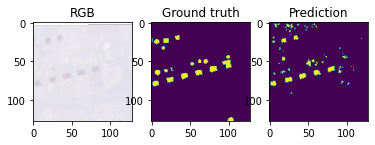

Confusion matrix :
[[15486   213]
 [  333   352]]
---
16384 pixels processed
Total accuracy : 96.66748046875%
---
F1Score :
No Buildings: 0.9826765657719398
Buildings: 0.5632
---
Kappa: 0.5460424897048861
Confusion matrix :
[[31454   435]
 [  402   477]]
---
32768 pixels processed
Total accuracy : 97.4456787109375%
---
F1Score :
No Buildings: 0.986869558396737
Buildings: 0.5326633165829145
---
Kappa: 0.5195374579358152
--------------Testing on patch number: 3----------------- 


/tmp/ipykernel_807/2835672629.py:131: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.conv1_1_D(x))


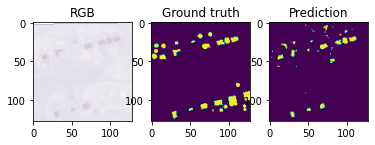

Confusion matrix :
[[15252   130]
 [  656   346]]
---
16384 pixels processed
Total accuracy : 95.20263671875%
---
F1Score :
No Buildings: 0.9748801534036433
Buildings: 0.46820027063599456
---
Kappa: 0.44639244820487356
Confusion matrix :
[[46706   565]
 [ 1058   823]]
---
49152 pixels processed
Total accuracy : 96.697998046875%
---
F1Score :
No Buildings: 0.9829220813384543
Buildings: 0.5035178953808505
---
Kappa: 0.48684144100443627
--------------Testing on patch number: 4----------------- 


/tmp/ipykernel_807/2835672629.py:131: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.conv1_1_D(x))


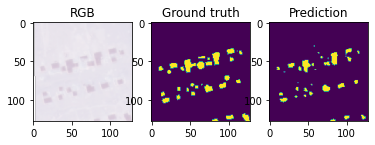

Confusion matrix :
[[15168    52]
 [  451   713]]
---
16384 pixels processed
Total accuracy : 96.929931640625%
---
F1Score :
No Buildings: 0.983689484094815
Buildings: 0.7392431311560393
---
Kappa: 0.7236721149298936
Confusion matrix :
[[61874   617]
 [ 1509  1536]]
---
65536 pixels processed
Total accuracy : 96.7559814453125%
---
F1Score :
No Buildings: 0.9831100942212053
Buildings: 0.5909965371296653
---
Kappa: 0.5746239170451534
--------------Testing on patch number: 5----------------- 


/tmp/ipykernel_807/2835672629.py:131: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.conv1_1_D(x))


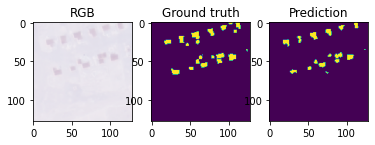

Confusion matrix :
[[15591    45]
 [  252   496]]
---
16384 pixels processed
Total accuracy : 98.187255859375%
---
F1Score :
No Buildings: 0.9905651386638712
Buildings: 0.769588828549263
---
Kappa: 0.760406979148818
Confusion matrix :
[[77465   662]
 [ 1761  2032]]
---
81920 pixels processed
Total accuracy : 97.042236328125%
---
F1Score :
No Buildings: 0.984601501083551
Buildings: 0.6264837367041776
---
Kappa: 0.6115448772550357
--------------Testing on patch number: 6----------------- 


/tmp/ipykernel_807/2835672629.py:131: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.conv1_1_D(x))


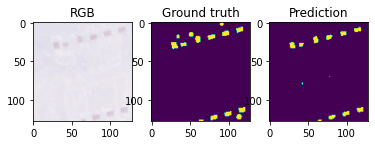

Confusion matrix :
[[15789    14]
 [  199   382]]
---
16384 pixels processed
Total accuracy : 98.699951171875%
---
F1Score :
No Buildings: 0.993299990563367
Buildings: 0.781985670419652
---
Kappa: 0.7755330026032005
Confusion matrix :
[[93254   676]
 [ 1960  2414]]
---
98304 pixels processed
Total accuracy : 97.31852213541667%
---
F1Score :
No Buildings: 0.9860635283170495
Buildings: 0.6468381564844587
---
Kappa: 0.6333298795815651
--------------Testing on patch number: 7----------------- 


/tmp/ipykernel_807/2835672629.py:131: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.conv1_1_D(x))


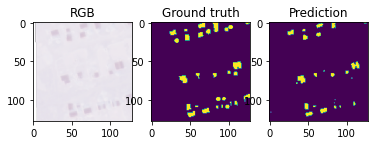

Confusion matrix :
[[15407    29]
 [  418   530]]
---
16384 pixels processed
Total accuracy : 97.271728515625%
---
F1Score :
No Buildings: 0.9857010332363009
Buildings: 0.7033842070338421
---
Kappa: 0.6900807183025018
Confusion matrix :
[[108661    705]
 [  2378   2944]]
---
114688 pixels processed
Total accuracy : 97.31183733258929%
---
F1Score :
No Buildings: 0.9860121140627481
Buildings: 0.6563370861665366
---
Kappa: 0.6428547622561049
--------------Testing on patch number: 8----------------- 


/tmp/ipykernel_807/2835672629.py:131: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.conv1_1_D(x))


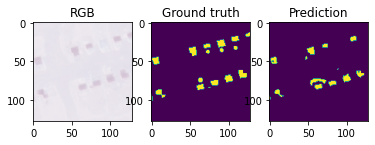

Confusion matrix :
[[15456    91]
 [  330   507]]
---
16384 pixels processed
Total accuracy : 97.430419921875%
---
F1Score :
No Buildings: 0.9865636868477324
Buildings: 0.7066202090592334
---
Kappa: 0.6935731818248859
Confusion matrix :
[[124117    796]
 [  2708   3451]]
---
131072 pixels processed
Total accuracy : 97.32666015625%
---
F1Score :
No Buildings: 0.986080766511214
Buildings: 0.663271189698251
---
Kappa: 0.6498406186314143
--------------Testing on patch number: 9----------------- 


/tmp/ipykernel_807/2835672629.py:131: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.conv1_1_D(x))


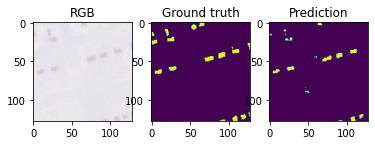

Confusion matrix :
[[15795    23]
 [  235   331]]
---
16384 pixels processed
Total accuracy : 98.42529296875%
---
F1Score :
No Buildings: 0.9918990203466466
Buildings: 0.7195652173913043
---
Kappa: 0.7119061496595821
Confusion matrix :
[[139912    819]
 [  2943   3782]]
---
147456 pixels processed
Total accuracy : 97.44873046875%
---
F1Score :
No Buildings: 0.9867341829286354
Buildings: 0.6678438989934664
---
Kappa: 0.6550625754690852
--------------Overall Accuracy: ----------------- 
Mean accuracy in test set is: 97.285724619709


[98.223876953125,
 97.4456787109375,
 96.697998046875,
 96.7559814453125,
 97.042236328125,
 97.31852213541667,
 97.31183733258929,
 97.32666015625,
 97.44873046875]

In [36]:
test()